In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date

In [4]:
#Choose start and end dates for the trip
#start date as Feb.23, 2018 and end date as Mar.10, 2018

trip_start_date=pd.to_datetime('2018-02-23', format='%Y-%m-%d')

trip_end_date=pd.to_datetime('2018-03-10',  format='%Y-%m-%d')

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
#inspect table columns and data
inspector=inspect(engine)

In [12]:
columns=inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns2=inspector.get_columns('station')
for column in columns2:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
#first date in dataset
first_date=session.query(Measurement.date).order_by(Measurement.date.asc()).first()

print(f' The first date in the dataset:{first_date.date}')

 The first date in the dataset:2010-01-01


In [15]:
#last date in dataset
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'The last date in the dataset:{last_date.date}')

The last date in the dataset:2017-08-23


Query period for precipitation results: 2016-08-23 to 2017-08-23


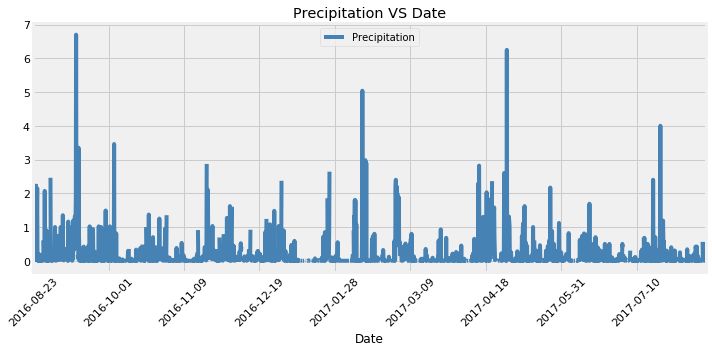

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

date_year_ago= date.fromisoformat(last_date.date)-dt.timedelta(days=365)

print(f'Query period for precipitation results: {date_year_ago} to {last_date.date}')

# Perform a query to retrieve the data and precipitation scores
prcp_query= session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=date_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df= pd.DataFrame(prcp_query, columns=('Date','Precipitation'))

# Sort the dataframe by date
prcp_df_sorted= prcp_df.sort_values(by='Date')
prcp_df_sorted.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df_sorted.plot(title='Precipitation VS Date',figsize=(10,5),grid=True, alpha=1, label=True, rot=45,color="steelblue" )

#formatting the plot
plt.legend(loc='upper center')
plt.tick_params(axis = 'both', which = 'major', labelsize = 11)
plt.tight_layout()

#Save precipitation vs date plot as image
plt.savefig('precipitation.png')

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df_sorted.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Station.id).count()
print(f'Total number of Stations in the dataset:{station_count}')

station_name=session.query(Measurement.station).distinct().all()
print("List of all stations:")
print(*station_name, sep="\n")

Total number of Stations in the dataset:9
List of all stations:
('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

print("List of Stations sorted by number of Observations:")
print(*active_stations, sep="\n")


List of Stations sorted by number of Observations:
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#most active station id
station_id=[active_station[0] for active_station in active_stations]

print(f'Most Active Station: {station_id[0]}')

Most Active Station: USC00519281


In [21]:
#lowest, avg and max temperatures recorded
temps=session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                   filter(Measurement.station==station_id[0]).all()
temps

[(54.0, 71.66378066378067, 85.0)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs=session.query(Measurement.tobs).filter(Measurement.station==station_id[0]).filter(Measurement.date>=date_year_ago).all()
                                    ## filter chosen based on last_date and date_year_ago calculated above
    
temp_obs_df=pd.DataFrame(temp_obs, columns=['Temp'])
temp_obs_df.head()

,Temp
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


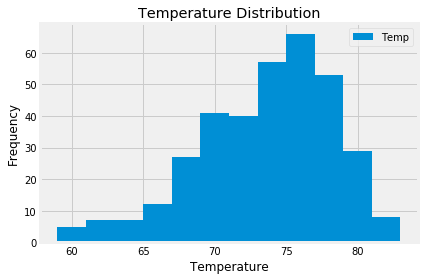

In [23]:
#Using DataFrame method to plot histogram with no of bins=12
temp_obs_df.plot.hist(bins=12,title='Temperature Distribution')
plt.xlabel("Temperature")
plt.tight_layout()
plt.savefig('Temp Histogram.png')

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()[0]

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.57142857142857, 74.0)


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date_yearago= trip_start_date.date()-dt.timedelta(days=365)
end_date_yearago= trip_end_date.date()- dt.timedelta(days=365)

[tmin,tavg, tmax]= calc_temps(start_date_yearago, end_date_yearago)

print(f' Based on previous year data for my trip starting on {trip_start_date.date()} and ending on {trip_end_date.date()}, recorded temperature stats are: \n Tmin: {tmin} \n Tavg: {tavg} \n Tmax: {tmax}' )

 Based on previous year data for my trip starting on 2018-02-23 and ending on 2018-03-10, recorded temperature stats are: 
 Tmin: 61.0 
 Tavg: 70.04 
 Tmax: 78.0


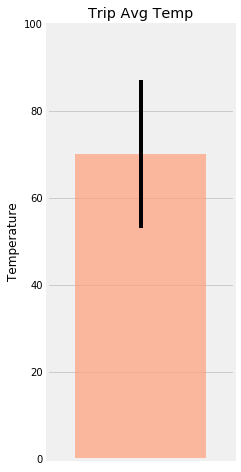

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(3,8))
plt.bar(0, tavg,  yerr=tmax-tmin, color="lightsalmon", width=1.4,alpha=0.7,)
plt.xlim((-1, 1))
plt.ylim((0, 100))
plt.xticks([])
plt.ylabel("Temperature")
plt.title("Trip Avg Temp")
plt.savefig('Avg_temp.png')

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall= session.query(Measurement.station, func.sum(Measurement.prcp)).\
       filter(Measurement.date >= start_date_yearago).filter(Measurement.date <= end_date_yearago).\
        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

print(*rainfall, sep="\n")

('USC00513117', 5.89)
('USC00519281', 5.4300000000000015)
('USC00516128', 4.2)
('USC00517948', 2.98)
('USC00519397', 2.78)
('USC00519523', 2.32)
('USC00514830', 1.79)


In [28]:
#Station.name, Station.latitude, Station.longitude, Station.elevation,

## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip--- (start_date_yearago, end_date_yearago)
# push each tuple of calculations into a list called `normals`
normals=[]

# Set the start and end date of the trip
start= dt.datetime.strptime(start_date_yearago.isoformat(),"%Y-%m-%d")
end= dt.datetime.strptime(end_date_yearago.isoformat(),"%Y-%m-%d")

# Use the start and end date to create a range of dates
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days)]

# Stip off the year and save a list of %m-%d strings
date_list=[]

for date in date_generated:
   date_list.append(date.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
for i in date_list:
    normals.append(daily_normals(i)[0])
    
normals

[(62.0, 70.35593220338983, 81.0),
 (61.0, 68.56666666666666, 76.0),
 (61.0, 68.59649122807018, 76.0),
 (62.0, 69.89285714285714, 78.0),
 (58.0, 69.98148148148148, 77.0),
 (65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0),
 (60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0)]

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df=pd.DataFrame(normals, index=date_list, columns=('TMin','TAvg','TMax'))

daily_normals_df

,TMin,TAvg,TMax
02-23,62.0,70.355932,81.0
02-24,61.0,68.566667,76.0
02-25,61.0,68.596491,76.0
02-26,62.0,69.892857,78.0
02-27,58.0,69.981481,77.0
02-28,65.0,70.655172,80.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0


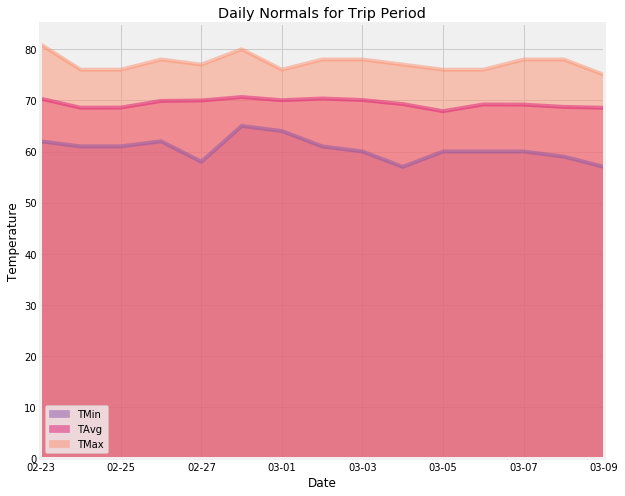

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(stacked=False, color=('#8856a7','#dd1c77','#fc9272'), title='Daily Normals for Trip Period', 
                           figsize=(9,8))

plt.xlabel("Date")
plt.ylabel("Temperature")

plt.savefig('Daily_normals.png')